<a href="https://colab.research.google.com/github/e-chong/Singapore-Ship-Detection/blob/master/Master_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

In [0]:
# install libraries

# suppress output
%%capture 

!pip install rasterio
!pip install geopandas
!pip install sentinelsat
!pip install satpy
!pip install glymur
!pip install python-geotiepoints
!pip install pyspectral
!pip install progressbar2
!pip install kaggle
!pip install tifffile

In [2]:
%tensorflow_version 1.x
%matplotlib inline

TensorFlow 1.x selected.


In [3]:
# Base dependencies
import numpy as np
import pandas as pd
import geopandas as gpd # vector spatial operations
import rasterio as rio # raster spatial operations
import json

# Plotting
from rasterio.plot import show #convenience wrapper for pyplot.imshow for RGB and 1 band images
import matplotlib.pyplot as plt

#Sentinel-2 I/O
from sentinelsat import SentinelAPI
from satpy.scene import Scene
from satpy import find_files_and_readers
import requests, zipfile, io, os, shutil # downloading and extracting zipfolders

# Sentinel-2 create patches
from shapely.geometry import Point # vector geometries
import time
import progressbar

# Resampling
from skimage.transform import resize
import tifffile as tiff
import scipy.ndimage

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import svm
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import regularizers
from keras.optimizers import RMSprop, SGD
from keras.utils import plot_model
from keras.applications import vgg16 


# Model Evaluation
from sklearn.metrics import confusion_matrix, auc, roc_curve

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Define Functions
credit to # https://gis.stackexchange.com/questions/299787/finding-pixel-location-in-raster-using-coordinates

In [0]:
# functions to download directly from Google Drive without linking
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [0]:
# Extracts RGB 3-channel image from SAFE directory and saves it in the working directory 
# and returns the path to the new file
def extract_rgb_jp2(safePath, sceneTitle):
  for subdirs, dirs, files in os.walk(safePath):
    for file in files:
      if file.endswith('_TCI.jp2'):
        rgbPath = os.path.join(subdirs, file)
        destPath = sceneTitle+'.jp2'
        print(f'Copying {file} to {destPath}')
        shutil.copy2(rgbPath, destPath)
        return destPath

In [0]:
# returns dataframe of x, y, patch_size
def create_ship_patches(ships, img, patch_size=50):
  coordinates = list(zip(ships.geometry.x, ships.geometry.y))
  x_list = []
  y_list = []
  with progressbar.ProgressBar(max_value=len(ships.index)) as bar: # creates progress bar
    patch_list = np.zeros([len(ships.index), patch_size, patch_size, len(img.indexes)])
    for i, (lon, lat) in enumerate(coordinates): # Loop through your list of coords
      py, px = img.index(lon, lat) # Get pixel coordinates from map coordinates
      window = rio.windows.Window(px - patch_size//2, py - patch_size//2, patch_size, patch_size) # Build an NxN window
      x_list.append(window.col_off)
      y_list.append(window.col_off)
      bar.update(i)
  results = pd.DataFrame({'isShip': True, 'x':x_list, 'y':y_list, 'patch_size':patch_size})
  return results

In [0]:
# creates patches for use in classifying ship or no ship
def create_patches(img, patch_size=50, step_size=30):
  n_patches = len(range(0,img.height, step_size)) * len(range(0,img.width, step_size))
  patch_list = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across image row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size)
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass
        else:
          # Read the data in the window
          patch = img.read(window=window) # patch is a nbands * patch_size * patch_size numpy array 
          patch_list.append(np.transpose(patch, (1,2,0))) # transpose to [patch_size, patch_size, n bands]
          index += 1
          bar.update(index)
  patch_array = np.stack(patch_list, axis=0)
  return patch_array.astype(int)

In [0]:
# returns boolean list of whether patches intersect with any ships
def patch_intersects_ship_buffers(ships, img, patch_size=50, step_size=30):
  n_patches = (len(range(0,img.height, step_size)) * len(range(0,img.width, step_size)))
  isShip_list = [] #list to hold all the patch locations
  buffer_list = []
  x_list = []
  y_list = []
  index = 0

  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across image row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          #create centroid point
          centroid = Point(img.transform *(window.col_off+patch_size/2, window.row_off+patch_size/2))
          buffer = centroid.buffer(img.transform[0]*step_size/1.5)
          buffer_list.append(buffer)
          isShip = np.any(ships.intersects(buffer)) #intersect ships with polygon and check if any are positive
          isShip_list.append(isShip) #append result to list
          x_list.append(x),
          y_list.append(y)
          index += 1
          bar.update(index)
  results = pd.DataFrame({'isShip':isShip_list, 'x':x_list, 'y':y_list, 'patch_size':patch_size})
  return results

In [0]:
# plots a patch
def plot_patch(img, x, y, patch_size=50):
  window = rio.windows.Window(x,y, patch_size, patch_size)
  patch = img.read(window=window)
  show(patch, title=f'x: {x}, y: {y}')

In [0]:
# creates patches for use in classifying ship or no ship
def predict_patch(model, img, x, y, patch_size=50):
  window = rio.windows.Window(x,y, patch_size, patch_size)
  patch = img.read(window=window) #get pixel values in window
  patch = np.interp(patch, (0,255), (0,1)) #remap values from (0,255) to (90,1)
  patch = np.transpose(patch, (1,2,0)) # re-arrange aces to (width, height, bands)
  patch = patch[np.newaxis, :] # add a new first axis to ake it the required shape for the model
  pred = model.predict_classes(patch) #predict patch class
  if pred == 1:
    return True
  else:
    return False

In [0]:
# Classifies dataframe of patches
def classify_patches(model, img, patches_df):
  pred_classes = []
  with progressbar.ProgressBar(max_value=len(patches_df.index)) as bar:
    index=0
    for i, row in patches_df.iterrows():
      pred = predict_patch(model, img, row.x, row.y, row.patch_size)
      pred_classes.append(pred)
      bar.update(index)
      index += 1
  return pred_classes

In [0]:
def evaluate_model(patches_df, pred_classes):
  eval_df = patches_df
  eval_df['pred_class'] = pred_classes
  eval_df['accurate'] = eval_df.isShip == eval_df.pred_class
  conditions = [(eval_df['isShip'] == False) & (eval_df['pred_class'] == False), 
                (eval_df['isShip'] == False) & (eval_df['pred_class'] == True), 
                (eval_df['isShip'] == True) & (eval_df['pred_class'] == False), 
                (eval_df['isShip'] == True) & (eval_df['pred_class'] == True)]
  choices = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
  eval_df['pred_type'] = np.select(conditions, choices)
  tn, fp, fn, tp = confusion_matrix(eval_df['isShip'], eval_df['pred_class']).ravel()
  print(f'True Positive: {tp}')
  print(f'True Negative: {tn}')
  print(f'False Positive: {fp}')
  print(f'False Negative: {fn}')
  print(f'Specificity: {round(tn/(tn+fp), ndigits=4)}')
  print(f'Sensitivity: {round(tp/(tp+fn), ndigits=4)}')
  print(f'Accuracy: {round((tp+tn)/(tn+fp+tp+fn), ndigits=4)}')
  print(f"Prevalence: {round(eval_df['isShip'].sum()/len(eval_df['isShip']), ndigits=4)}")
  print(f'Positive Predictive Value: {round(tp/(tp+fp), ndigits=4)}')
  return eval_df

In [0]:
# creates patches for use in classifying ship or no ship
def predict_patch_svm(model, img, x, y, patch_size=50):
  window = rio.windows.Window(x,y, patch_size, patch_size)
  patch = img.read(window=window) #get pixel values in window
  patch = np.interp(patch, (0,255), (0,1)) #remap values from (0,255) to (90,1)
  patch = np.transpose(patch, (1,2,0)) # re-arrange aces to (width, height, bands)
  patch = patch.reshape([patch.shape[0] * patch.shape[1] * patch.shape[2]])
  patch = patch[np.newaxis, :] # add a new first axis to ake it the required shape for the model
  pred = model.predict(patch) #predict patch class
  if pred == 1:
    return True
  else:
    return False

In [0]:
# Classifies dataframe of patches
def classify_patches_svm(model, img, patches_df):
  pred_classes = []
  with progressbar.ProgressBar(max_value=len(patches_df.index)) as bar:
    index=0
    for i, row in patches_df.iterrows():
      pred = predict_patch_svm(model, img, row.x, row.y, row.patch_size)
      pred_classes.append(pred)
      bar.update(index)
      index += 1
  return pred_classes

In [0]:
def plot_results(eval_df, pred_type, img, rows, cols):
  fig, ax = plt.subplots(rows, cols, figsize=(cols*3,rows*3))
  patches = eval_df.loc[eval_df['pred_type'] == pred_type].sample(n=rows*cols)
  index = 0
  for i in np.arange(0, rows):
    for j in np.arange(0, cols):
      window = rio.windows.Window(patches.x.iloc[index], patches.y.iloc[index], patches.patch_size.iloc[index], patches.patch_size.iloc[index])
      patch = img.read(window=window)
      show(patch, ax=ax[i,j], title=f'{patches.pred_type.iloc[index]}')
      index += 1
  plt.show()

# Define Parameters

In [0]:
DRIVE_PATH = '/content/drive/My Drive/MUSA-650-Final-Project/'

In [0]:
#Load param file
with open(DRIVE_PATH+'params.json', 'r') as file:
    params = json.load(file)
    
    SENTINEL_USER = params['SENTINEL_USER']
    SENTINEL_PWD = params['SENTINEL_PWD']
    KAGGLE_USER = params['KAGGLE_USER']
    KAGGLE_KEY = params['KAGGLE_KEY']

In [0]:
# unique Sentinel-2 tile id for images covering Singapore
TILE_ID = "48NUG"

In [0]:
# Patch parameters
PATCH_SIZE = 32
STEP_SIZE = 16

# Download Shipsnet Data

## Kaggle API

In [22]:
os.mkdir('.kaggle')
os.listdir()

FileExistsError: ignored

In [0]:
token = {"username":KAGGLE_USER,"key":KAGGLE_KEY}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

In [23]:
!kaggle datasets download -d rhammell/ships-in-satellite-imagery -p /content

ships-in-satellite-imagery.zip: Skipping, found more recently modified local copy (use --force to force download)


In [24]:
os.listdir()

['.config',
 'shipsnet.json',
 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2',
 'scenes',
 'drive',
 '.kaggle',
 'shipsnet',
 'image.jp2',
 'model.png',
 'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2',
 'ships-in-satellite-imagery.zip',
 'S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_20190406T073031.jp2',
 'sample_data']

In [0]:
with zipfile.ZipFile('ships-in-satellite-imagery.zip', 'r') as kaggleZip:
      kaggleZip.extractall(os.getcwd())

## Google Drive Direct Download

In [0]:
# # download 
# file_id = '1xaAUKqygRRKR_YOXoi55rxln3eVGTgY5'
# download_file_from_google_drive(file_id, 'shipsnet.json')

# Prepare Shipsnet for Modeling

In [27]:
with open('shipsnet.json') as data_file:
    shipsnet = json.load(data_file)
shipsnet.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

In [36]:
sn_patches = np.array(shipsnet['data']
             ).astype('uint8'
             ).reshape([-1, 3, 80, 80])
sn_patches = np.moveaxis(sn_patches, 1, 3)
sn_patches.shape

(4000, 80, 80, 3)

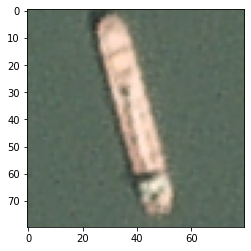

In [37]:
plt.imshow(sn_patches[100])

In [0]:
sn_patches_resize = np.zeros([sn_patches.shape[0],
                            PATCH_SIZE,
                            PATCH_SIZE,
                            sn_patches.shape[3]])

In [0]:
for img in range(sn_patches.shape[0]):
  sn_patches_resize[img] = resize(sn_patches[img], [PATCH_SIZE, PATCH_SIZE])

((4000, 32, 32, 3), <matplotlib.image.AxesImage at 0x7fec084f0a90>)

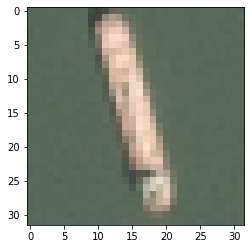

In [40]:
sn_patches_resize.shape, plt.imshow(sn_patches_resize[100])

In [41]:
sn_patches_resize.min(), sn_patches_resize.max()

(0.00514705882352943, 0.996078431372549)

In [42]:
#Prepare Data
x_train, x_test, y_train, y_test = train_test_split(sn_patches_resize, 
                                                    shipsnet['labels'], 
                                                    stratify=shipsnet['labels'], 
                                                    test_size=0.4, 
                                                    random_state=42)

np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([1800,  600])), (array([0, 1]), array([1200,  400])))

In [46]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# y_train = y_train.astype('int')
# y_test = y_test.astype('int')
num_classes = 2
y_train = to_categorical(y_train, num_classes, dtype='int')
y_test = to_categorical(y_test, num_classes, dtype='int')

2400 train samples
1600 test samples


In [47]:
x_train.min(), x_train.max()

(0.012745098039215658, 0.996078431372549)

In [48]:
y_train

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]])

# Train Model 1: SVM

In [0]:
x_svm = sn_patches_resize.reshape([sn_patches_resize.shape[0],
                    sn_patches_resize.shape[1] *
                    sn_patches_resize.shape[2] *
                    sn_patches_resize.shape[3]])

y_svm = np.array(shipsnet['labels'])

In [0]:
x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(x_svm, 
                                                    y_svm, 
                                                    stratify = y_svm, 
                                                    test_size=0.4, 
                                                    random_state=42)

In [51]:
# train SVM
svc = svm.SVC(verbose=1)
svc.fit(x_train_svm, y_train_svm)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=1)

In [0]:
# Test fitted SVM
yPred_svm = svc.predict(x_test_svm)
yTrainPred_svm = svc.predict(x_train_svm)
yProb_svm = svc.decision_function(x_test_svm)
fpr, tpr, thresh = roc_curve(y_test_svm, yProb_svm)
aucVal = auc(fpr, tpr)

In [53]:
# Optimize hyperparameters for 
svc = svm.SVC(verbose=1)

param_grid = {'kernel':('linear', 'sigmoid', 'rbf'), 
              'C': [1, 10, 100], 
              'gamma': ('scale', 'auto')}

search = GridSearchCV(svc, param_grid, 
                      verbose = 10,
                      n_jobs = -1,
                      cv = 10).fit(x_train_svm, y_train_svm)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 10

[LibSVM]

In [54]:
M1 = search.best_estimator_
M1

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=1)

In [55]:
# Outer 10-fold CV
nested_score = cross_val_score(M1, X=x_test_svm, y=y_test_svm, cv=10)
mean_accuracy = nested_score.mean()

print("Mean Accuracy (10-fold CV): " + str(mean_accuracy))
print("Maximum Fold Accuracy: " + str(nested_score.max()))
print("Minimum Fold Accuracy: " + str(nested_score.min()))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Mean Accuracy (10-fold CV): 0.9575000000000001
Maximum Fold Accuracy: 0.975
Minimum Fold Accuracy: 0.93125


# Train Model 2: Deep Convnet

In [56]:
# Structure Model
M2 = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(PATCH_SIZE, PATCH_SIZE, 3)),
                 Dropout(0.20),
                 Conv2D(64, (3, 3), padding='same', activation='relu'),
                 MaxPooling2D(pool_size=(2, 2)), #12x12
                 Dropout(0.20),
                 Conv2D(128, (3, 3), padding='same', activation='relu'),
                 MaxPooling2D(pool_size=(2, 2)), #6x6
                 Conv2D(512, (3, 3), padding='same', activation='softmax'),
                 MaxPooling2D(pool_size=(2, 2)), #3x3
                 Dropout(0.20),
                 Flatten(),
                 Dense(512, activation='relu'),
                 Dropout(0.20),
                 Dense(512, activation='softmax'),
                 Dense(2, activation='softmax')])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [57]:
M2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)        

In [0]:
M2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [59]:
# data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.7,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360)

# data augmentation configuration for test data:
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=128)

#train the model
M2.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 128)


Epoch 1/100
18/18 [==============================] - 3s 192ms/step - loss: 0.6846 - accuracy: 0.7491 - val_loss: 0.6716 - val_accuracy: 0.7487
Epoch 2/100
18/18 [==============================] - 1s 74ms/step - loss: 0.6604 - accuracy: 0.7518 - val_loss: 0.6258 - val_accuracy: 0.7466
Epoch 3/100
18/18 [==============================] - 1s 74ms/step - loss: 0.6214 - accuracy: 0.7478 - val_loss: 0.6082 - val_accuracy: 0.7520
Epoch 4/100
18/18 [==============================] - 1s 74ms/step - loss: 0.6045 - accuracy: 0.7469 - val_loss: 0.6292 - val_accuracy: 0.7500
Epoch 5/100
18/18 [==============================] - 1s 67ms/step - loss: 0.5912 - accuracy: 0.7518 - val_loss: 0.5598 - val_accuracy: 0.7527
Epoch 6/100
18/18 [==============================] - 1s 73ms/step - loss: 0.5807 - accuracy: 0.7561 - val_loss: 0.5656 - val_accuracy: 0.7493
Epoch 7/100
18/18 [==============================] - 1s 68ms/step - loss: 0.5819 - accuracy: 0.7451 - val_loss: 0.5256 - val_accuracy: 0.7554
Epoc

In [78]:
#Evaluating Shipsnet test loss and test accuracy
score2 = M2.evaluate(x_test, y_test, verbose=0)
print('Shipsnet Test loss:', score2[0])
print('Shipsnet Test accuracy:', score2[1])

Shipsnet Test loss: 0.5623384499549866
Shipsnet Test accuracy: 0.75


# Train Model 3: Shallow Convnet

In [0]:
M3 = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(PATCH_SIZE, PATCH_SIZE, 3)),
                 Dropout(0.20),
                 Conv2D(64, (3, 3), padding='same', activation='relu'),
                 MaxPooling2D(pool_size=(2, 2)), #12x12
                 Dropout(0.20),
                 Flatten(),
                 Dense(2, activation='softmax')])

In [90]:
M3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

In [0]:
M3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [92]:
# data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360)

# data augmentation configuration for test data:
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=128)

#train the model
M3.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 128)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
18/18 [==============================] - 1s 68ms/step - loss: 0.5721 - accuracy: 0.7394 - val_loss: 0.5455 - val_accuracy: 0.7578
Epoch 2/50
18/18 [==============================] - 1s 67ms/step - loss: 0.4456 - accuracy: 0.7953 - val_loss: 0.4311 - val_accuracy: 0.8261
Epoch 3/50
18/18 [==============================] - 1s 62ms/step - loss: 0.3560 - accuracy: 0.8372 - val_loss: 0.3273 - val_accuracy: 0.8791
Epoch 4/50
18/18 [==============================] - 1s 56ms/step - loss: 0.3141 - accuracy: 0.8643 - val_loss: 0.2983 - val_accuracy: 0.8770
Epoch 5/50
18/18 [==============================] - 1s 63ms/step - loss: 0.2810 - accuracy: 0.8812 - val_loss: 0.3478 - val_accuracy: 0.8546
Epoch 6/50
18/18 [==============================] - 1s 61ms/step - loss: 0.2754 - accuracy: 0.8785 - val_loss: 0.2575 - val_accuracy: 0.9015
Epoch 7/50
18/18 [==============================] - 1s 64ms/

# Train Model 4: VGG16

In [0]:
conv_base = vgg16.VGG16(include_top=False,
            input_shape = (PATCH_SIZE, PATCH_SIZE, 3))

conv_base.summary()

In [0]:
# freeze the weights
for layer in conv_base.layers:
  layer.trainable = False

In [0]:
model_file = DRIVE_PATH + 'models/M2.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

In [0]:
M4 = Sequential()

M4.add(conv_base)

M4.add(Flatten())
M4.add(Dense(512, activation='relu'))
M4.add(Dropout(0.2))
M4.add(Dense(2, activation='sigmoid'))

M4.summary()

In [0]:
plot_model(M2, show_shapes=True, show_layer_names=True)

In [0]:
opt = SGD(lr=0.01)

M4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# data augmentation configuration for test data:
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=128)

m4_history = M4.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 128)

# Download Sentinel-2 Data

## Sentinel Hub API

In [61]:
# Sentinel API Query
api = SentinelAPI(SENTINEL_USER, SENTINEL_PWD, 'https://scihub.copernicus.eu/dhus')

scenes = api.to_geodataframe(api.query(tileid=TILE_ID,
                                             date=('20100101','NOW'),
                                             platformname='Sentinel-2',
                                             cloudcoverpercentage=(0, 6)))
#get full scene metadata
tempList = list()
for uuid in scenes.uuid:
  tempList.append(api.get_product_odata(uuid, full=True))

sceneMeta = pd.DataFrame(tempList)
sceneMeta = sceneMeta.loc[sceneMeta['Online'] == True] # filter out images that are in Long Term Archive and have a 30 minute throttle to download

sceneMeta

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,id,title,size,md5,date,footprint,url,Online,Creation Date,Ingestion Date,Cloud cover percentage,Datatake sensing start,Date,Degraded ancillary data percentage,Degraded MSI data percentage,Filename,Footprint,Format,Format correctness,General quality,Generation time,Geometric quality,Identifier,Instrument,Instrument abbreviation,Instrument mode,Instrument name,JTS footprint,Mission datatake id,NSSDC identifier,Orbit number (start),Pass direction,Platform serial identifier,Processing baseline,Processing level,Product type,Radiometric quality,Relative orbit (start),Satellite,Satellite name,Satellite number,Sensing start,Sensing stop,Sensor quality,Size,Tile Identifier,Tile Identifier horizontal order,Level-1C PDI Identifier,Datastrip identifier,Granule identifier
0,8345c17f-dd76-4398-b4bf-2eb708631b07,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,784125118,FCD2A37B4A069C5342299AD2AEE90B41,2019-12-27 03:21:31.024,"POLYGON((103.20205689083804 1.808922187860351,...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,True,2019-12-27 08:04:08.105,2019-12-27 08:03:15.620,3.6098,2019-12-27 03:21:31.024,2019-12-27 03:21:31.024,0.0,0,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,"<gml:Polygon srsName=""http://www.opengis.net/g...",SAFE,PASSED,PASSED,2019-12-27 06:07:36,PASSED,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,MSI,MSI,INS-NOBS,Multi-Spectral Instrument,MULTIPOLYGON (((103.2027660714231 0.8160247595...,GS2A_20191227T032131_023567_N02.08,2015-028A,23567,DESCENDING,Sentinel-2A,2.08,Level-1C,S2MSI1C,PASSED,118,Sentinel-2,Sentinel-2,A,2019-12-27 03:21:31.024,2019-12-27 03:21:31.024,PASSED,747.76 MB,48NUG,NG48U,S2A_OPER_MSI_L1C_TL_EPAE_20191227T060736_A0235...,NaN,NaN
1,5d57f964-03cb-4001-a2f2-33f9eba9605e,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,779449455,5E51BCC8A45CF3ADD026433463D37D58,2019-07-05 03:15:49.024,"POLYGON((103.20205689083804 1.808922187860351,...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,True,2019-07-05 10:32:33.443,2019-07-05 09:41:20.667,5.5518,2019-07-05 03:15:49.024,2019-07-05 03:15:49.024,0.0,0,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,"<gml:Polygon srsName=""http://www.opengis.net/g...",SAFE,PASSED,PASSED,2019-07-05 06:53:23,PASSED,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,MSI,MSI,INS-NOBS,Multi-Spectral Instrument,MULTIPOLYGON (((103.2027660714231 0.8160247595...,GS2B_20190705T031549_012156_N02.07,2017-013A,12156,DESCENDING,Sentinel-2B,2.07,Level-1C,S2MSI1C,PASSED,118,Sentinel-2,Sentinel-2,B,2019-07-05 03:15:49.024,2019-07-05 03:15:49.024,PASSED,743.30 MB,48NUG,NG48U,S2B_OPER_MSI_L1C_TL_SGS__20190705T065323_A0121...,NaN,NaN


In [62]:
# download sentinel images available online
for index, row in sceneMeta.iterrows():
  uuid = row['id']
  title = row['title']
  filename = row['Filename']
  print(f'Downloading {title}')
  api.download(uuid)

Downloading: 100%|██████████| 784M/784M [00:45<00:00, 17.1MB/s]
MD5 checksumming: 100%|██████████| 784M/784M [00:01<00:00, 472MB/s]


Downloading: 100%|██████████| 779M/779M [00:35<00:00, 21.9MB/s]
MD5 checksumming: 100%|██████████| 779M/779M [00:01<00:00, 492MB/s]


In [63]:
# Unzip folders
# this creates SAFE files/directories which are explained here: https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/data-formats
for index, row in sceneMeta.iterrows(): 
    title = row['title']
    filename = row['Filename']
    print(f'Unzipping {title}')
    with zipfile.ZipFile(title+'.zip', 'r') as safezip:
      safezip.extractall(filename)

Unzipping S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736
Unzipping S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323


In [64]:
image_paths = []
for index, row in sceneMeta.iterrows():
  image_paths.append(extract_rgb_jp2(row['Filename'], row['title']))
print(image_paths)

Copying T48NUG_20191227T032131_TCI.jp2 to S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2
Copying T48NUG_20190705T031549_TCI.jp2 to S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2
['S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2', 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2']


In [65]:
# delete unneeded files to free up space
for name in sceneMeta.title:
  if os.path.exists(name+'.zip'):
    print(f'Deleting {name}.zip')
    os.remove(name+'.zip')
  if os.path.exists(name+'.SAFE'):
    print(f'Deleting {name}.SAFE')
    shutil.rmtree(name+'.SAFE')

Deleting S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.zip
Deleting S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.SAFE
Deleting S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.zip
Deleting S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.SAFE


## Google Drive Direct Download

In [0]:
sentinel_file_ids = {
    'S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_20190406T073031.jp2':'1s6yyxxp1tuON-OztYRWi3VxZyQgU5j5x',
    'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2':'1sSafqtDo9Uj6VByj7XGmyzAMOHEF52kz',
    'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2':'1DVWkhY2jmjZmdNNDCYF-J33n8CG-F6lG',
    'S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_20190406T073031.geojson':'14eT7PTG0NZzMVJVzwSe35KF7r6N27QnM',
    'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.geojson':'1y3ZMhSMJTG0d6yBm6mdK4_y8iugpGBOu',
    'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.geojson':'11BmAdav1tYnFe9Lr84Dh2TglGswzSA3m'
}

In [0]:
# for file_name, file_id in sentinel_file_ids.items():
#   download_file_from_google_drive(file_id, file_name)

# Prepare Sentinel-2 for Modeling

In [0]:
# load ship points and scene
scene_name = sceneMeta.title[1] # 
ship_points = gpd.read_file(DRIVE_PATH+scene_name+'_SHIPS.geojson')
sat_img = rio.open(scene_name+'.jp2')

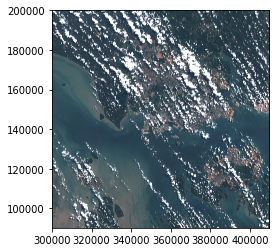

In [69]:
show(sat_img)

In [70]:
sentinel_patch_classes = patch_intersects_ship_buffers(ships = ship_points, 
                                                       img=sat_img, 
                                                       patch_size=PATCH_SIZE, 
                                                       step_size=STEP_SIZE)

100% (471969 of 471969) |################| Elapsed Time: 0:11:47 Time:  0:11:47


In [0]:
csv_path = DRIVE_PATH + scene_name + '_' + str(PATCH_SIZE) + '.csv'
sentinel_patch_classes.to_csv(csv_path, index = False)
# sentinel_patch_classes = pd.read_csv(csv_path)

In [72]:
sentinel_patch_classes.groupby('isShip')['isShip'].count()

isShip
False    468777
True        448
Name: isShip, dtype: int64

In [0]:
frac = 0.1

sentinel_sample = (sentinel_patch_classes
                   .groupby('isShip', # stratify by isShip
                            group_keys = False)
                   .apply(lambda x: x.sample(frac = frac, # sample by group
                                             random_state = 123))
                   .sort_index()) # the index needs to be sorted for the sample patches to "line up" with `sentinel_sample`

In [74]:
sentinel_sample.groupby('isShip')['isShip'].count()

isShip
False    46878
True        45
Name: isShip, dtype: int64

In [75]:
sentinel_sample.head()

,isShip,x,y,patch_size
9,False,144,0,32
10,False,160,0,32
11,False,176,0,32
46,False,736,0,32
51,False,816,0,32


# Evaluate Models
Evaluate the four models on sentinel-2 and visualize the types of errors.

## Model 1

In [76]:
m1_pred_classes = classify_patches_svm(M1, sat_img, sentinel_sample)
m1_eval = evaluate_model(sentinel_sample, m1_pred_classes)

100% (46923 of 46923) |##################| Elapsed Time: 0:02:05 Time:  0:02:05


True Positive: 0
True Negative: 46844
False Positive: 34
False Negative: 45
Specificity: 0.9993
Sensitivity: 0.0
Accuracy: 0.9983
Prevalence: 0.001
Positive Predictive Value: 0.0


In [0]:
#plot_results(m1_eval, 'True Positive', sat_img, rows=1, cols =0)

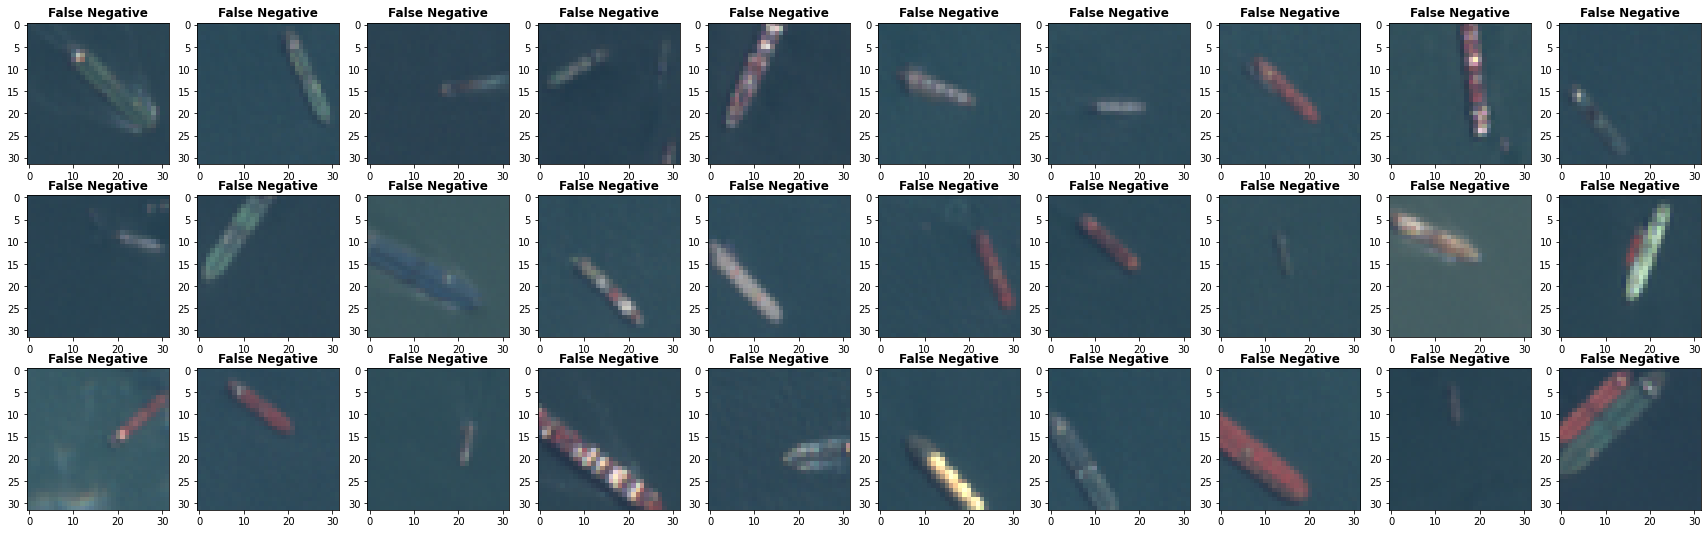

In [79]:
plot_results(m1_eval, 'False Negative', sat_img, rows=3, cols =10)

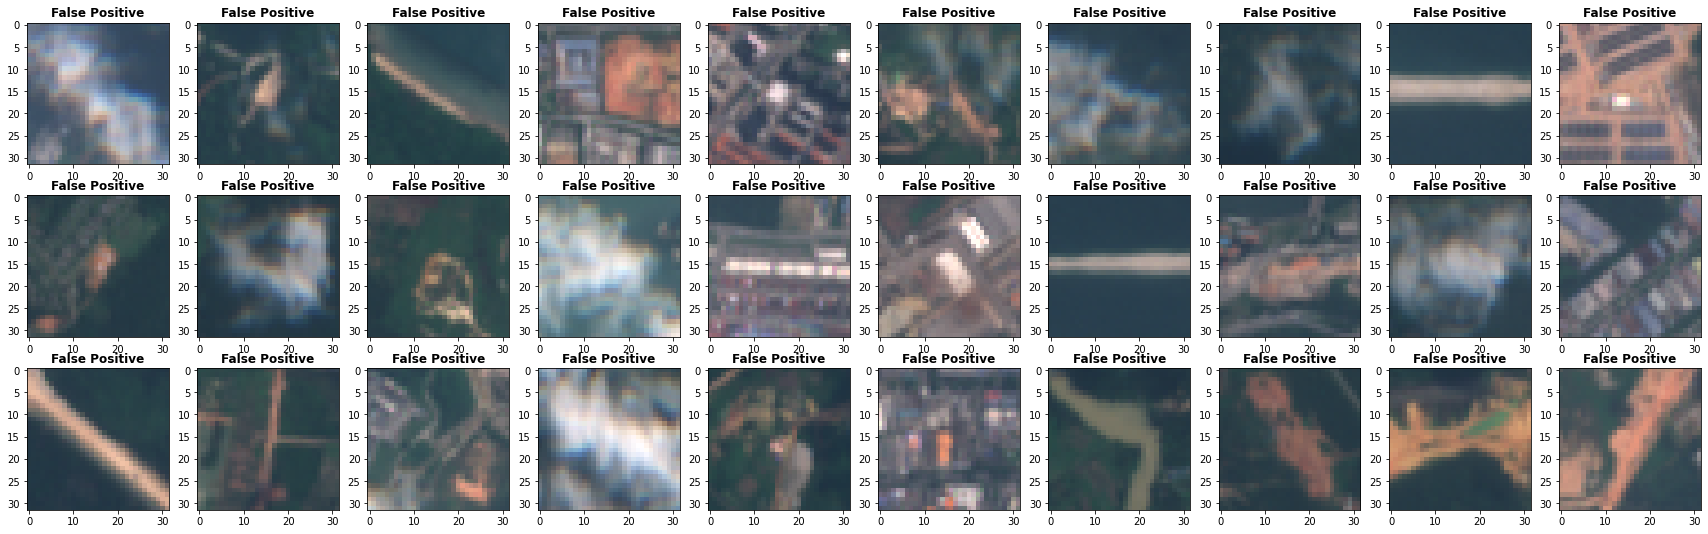

In [80]:
plot_results(m1_eval, 'False Positive', sat_img, rows=3, cols =10)

## Model 2

In [81]:
m2_pred_classes = classify_patches(M2, sat_img, sentinel_sample)
m2_eval = evaluate_model(sentinel_sample, m2_pred_classes)

100% (46923 of 46923) |##################| Elapsed Time: 0:01:55 Time:  0:01:55


True Positive: 0
True Negative: 46878
False Positive: 0
False Negative: 45
Specificity: 1.0
Sensitivity: 0.0
Accuracy: 0.999
Prevalence: 0.001
Positive Predictive Value: nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


ValueError: ignored

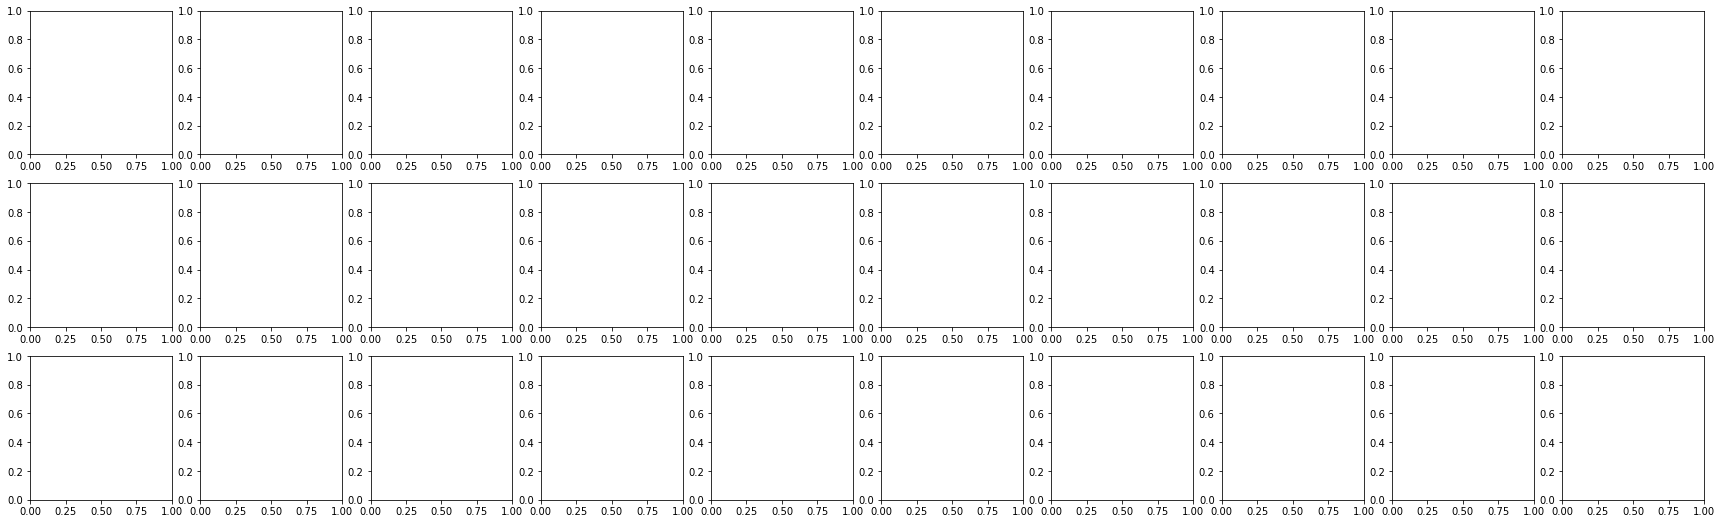

In [82]:
plot_results(m2_eval, 'True Positive', sat_img, rows=3, cols =10)

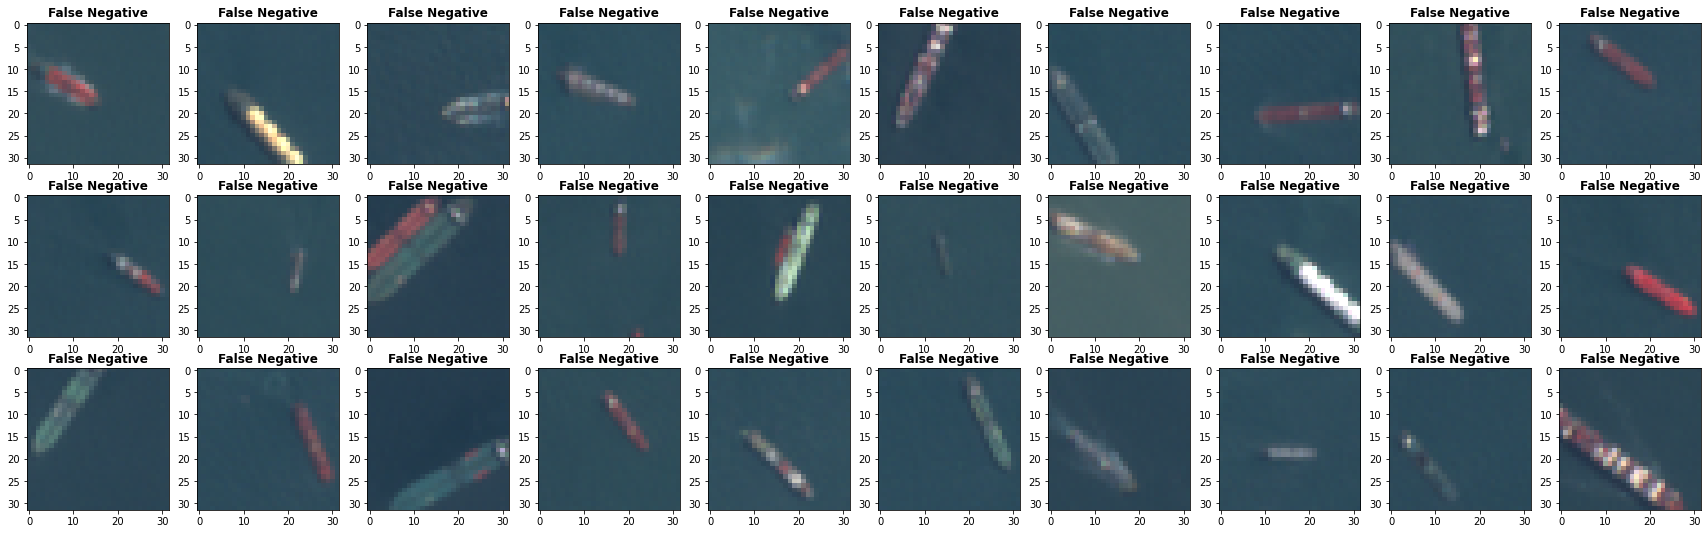

In [84]:
plot_results(m2_eval, 'False Negative', sat_img, rows=3, cols =10)

ValueError: ignored

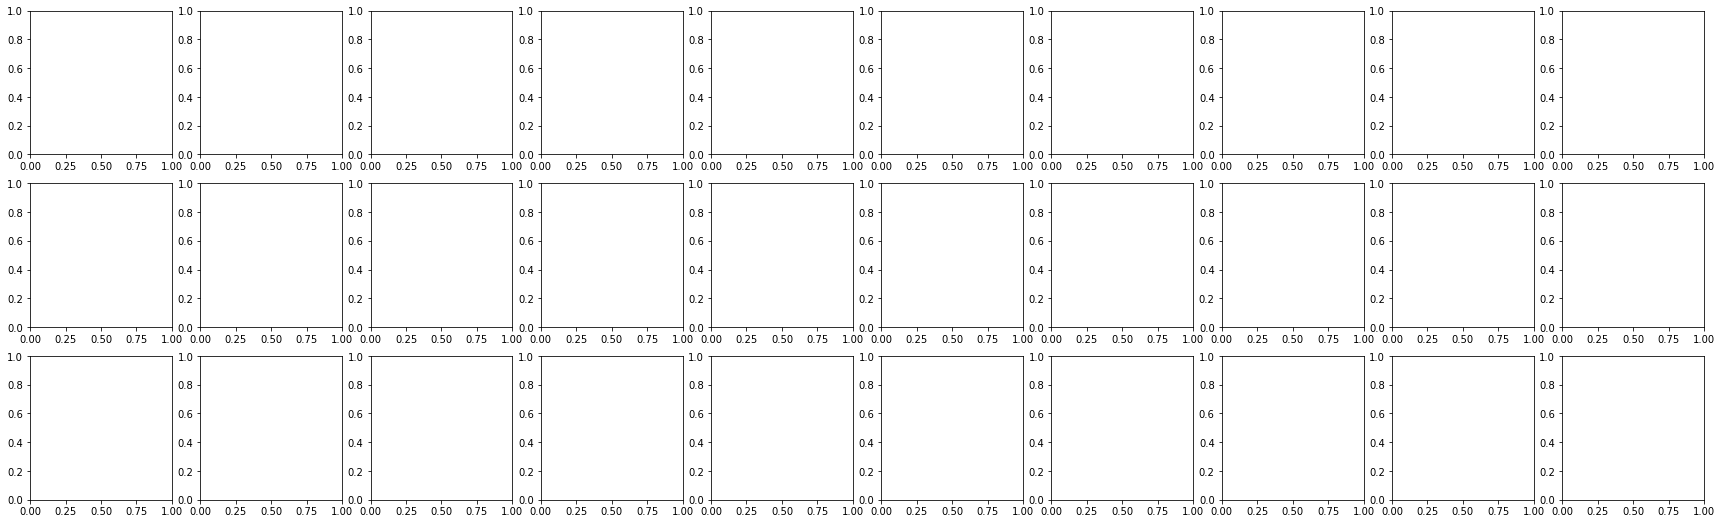

In [85]:
plot_results(m2_eval, 'False Positive', sat_img, rows=3, cols =10)

## Model 3

In [87]:
m3_pred_classes = classify_patches(M3, sat_img, sentinel_sample)
m3_eval = evaluate_model(sentinel_sample, m3_pred_classes)

NameError: ignored

In [0]:
plot_results(m3_eval, 'True Positive', sat_img, rows=2, cols =2)

In [0]:
plot_results(m3_eval, 'False Negative', sat_img, rows=3, cols =8)

In [0]:
plot_results(m3_eval, 'False Positive', sat_img, rows=3, cols =10)

## Model 4

In [88]:
m4_pred_classes = classify_patches(M4, sat_img, sentinel_sample)
m4_eval = evaluate_model(sentinel_sample, m4_pred_classes)

NameError: ignored

In [0]:
plot_results(m4_eval, 'True Positive', sat_img, rows=2, cols =4)

In [0]:
plot_results(m4_eval, 'False Negative', sat_img, rows=3, cols =10)

In [86]:
plot_results(m4_eval, 'False Positive', sat_img, rows=3, cols =10)

NameError: ignored